# Time Series Forecasting with NeuralForecast 

In this tutorial, we will explain how to forecast time series data using Nixtla's [NeuralForecast](https://nixtlaverse.nixtla.io/neuralforecast/index.html). NeuralForecast is a Python library that offers a large collection of neural forecasting models, focusing on their performance, usability, and robustness.

We will use the [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy) dataset, which contains hierarchical sales data from Walmart spanning five years. The goal of this tutorial is to forecast sales for the next 28 days.

First, we will generate several models from NeuralForecast and use time series cross-validation on the training set to select the best model for each series. Then, we will generate a 28-day-ahead forecast, mirroring the approach used in the competition. Finally, we will compare our forecast with the competition's test set to evaluate overall performance.

**Outline:**
1. Load and Visualize the Data
2. Perform Time Series Cross-Validation
3. Select the Best Model for Each Series
4. Fit and Predict
5. Evaluate the Results

## 1. Load and Visualize the Data 

We can download the M5 Competition dataset from a parquet file using `pandas`.

In [257]:
import pandas as pd 

Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')
Y_df.head()

,item_id,timestamp,demand
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0


We need to adjust the columns to conform to NeuralForecast's requirements. The input to NeuralForecast should be a DataFrame in long format with three columns: 

- `unique_id` (string, int or category): A unique identifier for each series. 

- `ds` (int or timestamp): An integer indexing time or a timestamp in format 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'.

- `y` (numeric): The target variable to forecast, in this case, daily sales. 

In [258]:
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

Y_df['unique_id'] = Y_df['unique_id'].astype(str)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

The complete M5 Competition dataset contains 30,490 series, with each series representing the daily sales of a specific item. These items are organized in a hierarchical structure across multiple levels: department, category, store, and state.

You can leverage the capabilities of LightningAI to generate a forecast for all the series in the dataset or you can select a sample of series. To select all the series that correspond to a specific department, for example, you can simply filter the dataset and then continue with the tutorial.

```python
Y_df = Y_df[Y_df['unique_id'].str.contains("FOODS_3_001")].reset_index(drop=True)
``````

We will use the `plot_series` function from [utilsforecast](https://nixtlaverse.nixtla.io/utilsforecast/index.html) to visualize the data. utilsforecast is Python library from Nixtla designed to support various forecasting tasks. 

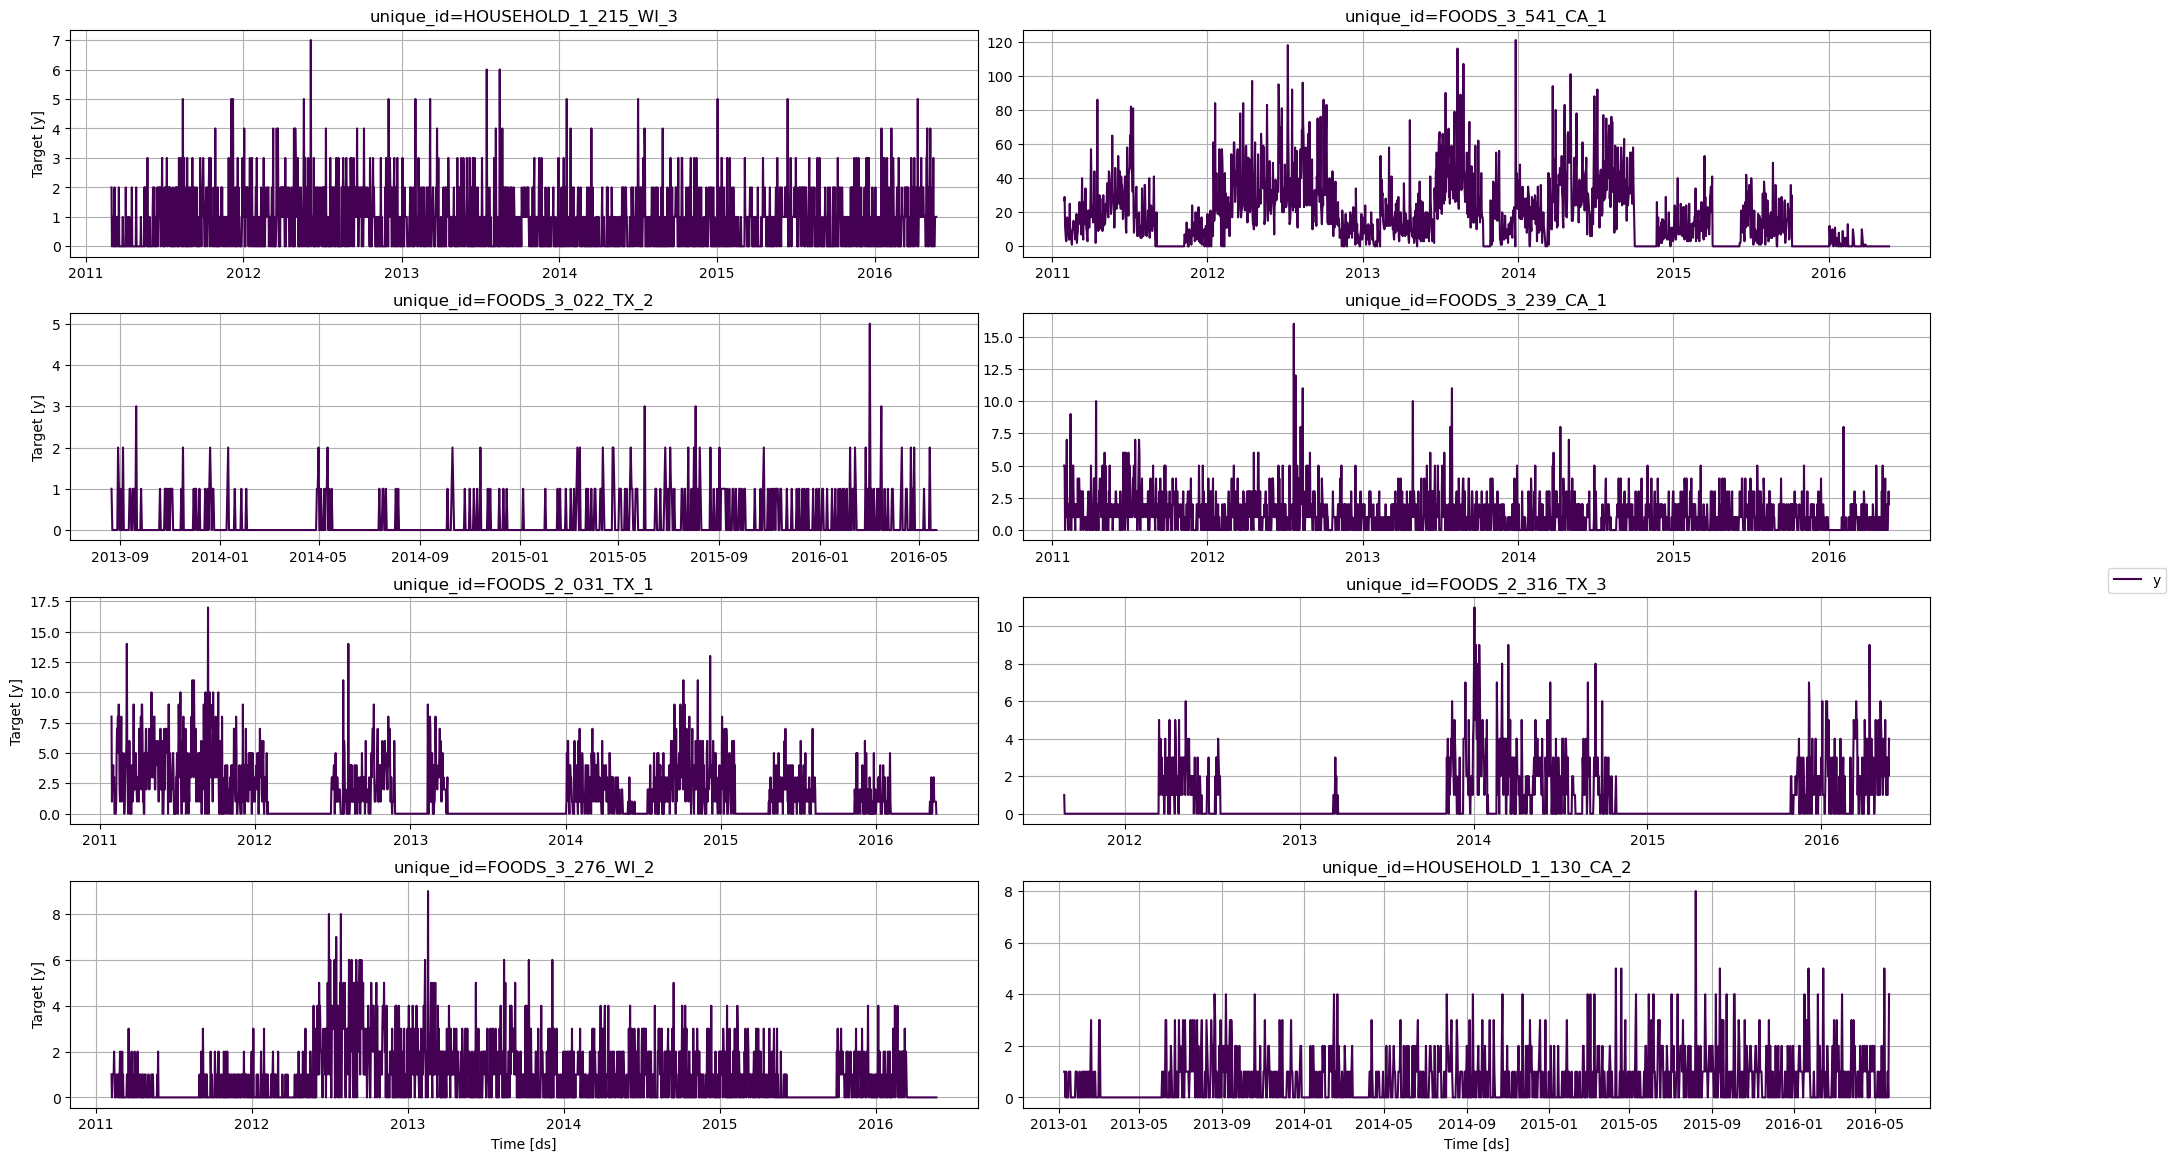

In [93]:
from utilsforecast.plotting import plot_series 

plot_series(Y_df, engine='plotly')

The `plot_series` function takes the following arguments: 

- `df` (DataFrame): The input data with columns `unique_id`, `ds`, and `y`.

- `max_insample_length` (int): The maximum number of observations to plot. 

- `engine` (str): The plotting engine to use: 'plotly' or 'matplotlib'. 

## 2. Perform Time Series Cross-Validation

In this section, we will generate several models using NeuralForecast and then select the best model for each series using time series cross-validation.

Time series cross-validation is a method for evaluating how a model would have performed on historical data. It works by defining a sliding window across past observations and then predicting the period following it. This method differs from standard cross-validation by maintaining the chronological order of the data instead of randomly splitting it. 

Before running the cross-validation, we need to import the models from NeuralForecast that we will use. Keep in mind that their performance is greatly affected by the choice of hyperparameters. NeuralForecast has automatized and simplified the hyperparameter tuning process with the `Auto` models. Each model in the library has an `Auto` version that performs hyperparameter selection on either a default or custom search space.

The `Auto` models can be used with two backends: Ray's [Tune](https://docs.ray.io/en/master/tune/index.html) and [Optuna](https://optuna.org/). In this tutorial, we will use the `AutoNHITS`, `AutoTFT`, and `AutoDeepAR` models with Ray's Tune backend and a custom search space. 

In [262]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoTFT, AutoDeepAR
from neuralforecast.losses.pytorch import DistributionLoss

To instantiate an `Auto` model we need to define the following parameters: 

- `h` (int): The forecast horizon.

- `loss`: Training and validation loss from `neuralforecast.losses.pytorch`.

- `config` (dict): A dictionary with the hyperparameter search space. 

- `search_alg`: The search algorithm to use. Default is random search. 

- `num_samples` (int): Number of configurations explored. 

In this tutorial, we will set `h=28`, mirroring the M5 Competition, and will use a `Poisson` loss with a custom search space as defined below. We will use the default search algorithm and explore two configurations, so we will set `num_samples=2``.

In [263]:
config_nhits = {
    "input_size": tune.choice([28, 28*2, 28*3, 28*5]),              
    "n_blocks": 5*[1],                                              
    "mlp_units": 5 * [[512, 512]],                                  
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   
    "scaler_type": tune.choice([None]),                             
    "max_steps": tune.choice([1000]),                               
    "batch_size": tune.choice([32, 64, 128, 256]),                  
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),       
    "random_seed": tune.randint(1, 20),                            
}

config_tft = {
        "input_size": tune.choice([28, 28*2, 28*3]),                
        "hidden_size": tune.choice([64, 128, 256]),                 
        "learning_rate": tune.loguniform(1e-4, 1e-2),               
        "scaler_type": tune.choice([None]),                        
        "max_steps": tune.choice([500, 1000]),                      
        "batch_size": tune.choice([32, 64, 128, 256]),              
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),  
        "random_seed": tune.randint(1, 20),                         
    }

config_deepar = {
    "input_size": tune.choice([28, 28*2, 28*3]),                 
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "scaler_type": tune.choice([None]),
    "max_steps": tune.choice([500, 1000]),
    "batch_size": tune.choice([32, 64, 128, 256]),
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),
    "random_seed": tune.randint(1, 20),
    }



Now that we have defined the search space for each model, we can instantiate the NeuralForecast class. 

In [264]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=28, config=config_nhits, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2),
        AutoTFT(h=28, config=config_tft, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2), 
        AutoDeepAR(h=28, config=config_deepar, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2)
    ],
    freq='D'
)

The `cross_validation` method takes the following arguments: 

- `df` (DataFrame): The input data in the format described in the previous section. 

- `n_windows` (int): The number of windows to evaluate. Default is 1 and we will use 3. 

- `step_size` (int): The number of steps between consecutive windows to produce the forecasts. In this tutorial, we will set `step_size=28`, which is the forecast horizon. 

In [7]:
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=28)

(pid=86324) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=86324)   "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
(pid=86324) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=86324)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=86324) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:265: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=86324)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=86324) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFram

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  42%|████▏     | 100/239 [00:06<00:09, 15.16it/s, v_num=0, train_loss_step=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/239 [00:00<?, ?it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   0%|          | 1/239 [00:00<01:56,  2.04it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|          | 2/239 [00:01<02:02,  1.93it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|▏         | 3/239 [00:01<02:07,  1.85it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   2%|▏         | 4/239 [00:02<02:05,  1.88it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   2%|▏         | 5/239 [00:02<02:03,  1.89it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   3%|▎         | 6/239 [00:03<02:02,  1.90it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   3%|▎         | 7/239 [00:03<02:02,  1.90it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   3%|▎     

(_train_tune pid=86324) Seed set to 12


Epoch 0:  21%|██        | 100/477 [00:04<00:15, 23.90it/s, v_num=0, train_loss_step=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/477 [00:00<?, ?it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   0%|          | 1/477 [00:00<02:29,  3.18it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   0%|          | 2/477 [00:00<02:26,  3.24it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|          | 3/477 [00:00<02:27,  3.21it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|          | 4/477 [00:01<02:33,  3.08it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|          | 5/477 [00:01<02:32,  3.09it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|▏         | 6/477 [00:01<02:30,  3.13it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   1%|▏         | 7/477 [00:02<02:29,  3.14it/s]
(_train_tune pid=86324) 
Validation DataLoader 0:   2%|▏         | 8/477 [00:02<02:30,  3.12it/s]
(_train_tune p

Seed set to 4


(_train_tune pid=86324) 
Epoch 2:  10%|▉         | 46/477 [02:19<21:45,  0.33it/s, v_num=0, train_loss_step=1.260, valid_loss=0.501, train_loss_epoch=1.370]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

(_train_tune pid=86324) /Users/marianamenchero/miniforge3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=86324)   warnings.warn('resource_tracker: There appear to be %d '


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

The output of the `cross_validation` method is a DataFrame with the following columns:

- `unique_id`: The unique identifier for each series.

- `ds`: The timestamp or temporal index. 

- `cutoff`: The last timestamp or temporal index used in that cross-validation window. 

- `model`: Columns with the model's point and median forecast. By default, the 80 and 90% prediction intervals are also included when using the `Poisson` loss.

- `y`: The actual variable 

In [269]:
cv_df = cv_df.reset_index()
cv_df.head()

,index,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,...,AutoTFT-lo-80,AutoTFT-hi-80,AutoTFT-hi-90,AutoDeepAR,AutoDeepAR-median,AutoDeepAR-lo-90,AutoDeepAR-lo-80,AutoDeepAR-hi-80,AutoDeepAR-hi-90,y
0,0,FOODS_1_001_CA_1,2016-02-29,2016-02-28,0.557,0.5,0.000000,0.900002,0.900024,0.049988,...,1.800003,0.000000,0.049988,0.59,0.0,0.0,0.0,2.0,2.000000,1.0
1,1,FOODS_1_001_CA_1,2016-03-01,2016-02-28,0.610,0.0,1.000000,0.099998,0.000000,0.950012,...,0.900002,1.000000,1.900024,0.75,1.0,0.0,0.0,2.0,2.049995,0.0
2,2,FOODS_1_001_CA_1,2016-03-02,2016-02-28,0.730,0.5,0.099998,1.000000,0.199951,0.049988,...,0.099998,0.000000,1.900024,0.62,0.0,0.0,0.0,2.0,2.000000,1.0
3,3,FOODS_1_001_CA_1,2016-03-03,2016-02-28,0.654,0.5,0.049999,0.900002,2.099976,0.950012,...,1.800003,2.900024,0.049988,0.78,1.0,0.0,0.0,2.0,2.000000,0.0
4,4,FOODS_1_001_CA_1,2016-03-04,2016-02-28,0.644,1.0,1.000000,0.000000,0.900024,0.099976,...,0.099998,0.099976,0.099976,0.51,0.0,0.0,0.0,1.0,2.000000,0.0


In [272]:
# Load previously generated results 
cv_df = pd.read_csv('cv_df.csv')

The M5 Competition featured two tracks: accuracy and uncertainty. The accuracy track aimed to estimate the point forecasts of unit sales, while the uncertainty track focused on estimating the uncertainty distribution of the realized values of these sales.

In this tutorial, we will focus on the accuracy track of the competition; therefore, we will only use the point forecasts from the `Auto` models.

In [274]:
cv_df = cv_df[['unique_id', 'ds', 'cutoff', 'y', 'AutoNHITS', 'AutoDeepAR', 'AutoTFT']]

plot_series(Y_df, cv_df.drop(columns=['y', 'cutoff']), max_insample_length=300, engine='plotly')

## 3. Select the Best Model for Each Series

To evaluate the point forecasts of the models, we will use the Root Mean Squared Error (RMSE), defined as squared root of the average squared errors. For convinience, we will use the `evaluate` and `rmse` functions from utilsforecast.

In [276]:
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import rmse 

The `evaluate` function takes the following arguments:

- `df` (DataFrame): The data frame with the forecasts to evaluate.

- `metrics` (list): The metrics to compute.

- `models` (list): Names of the models to evaluate. Default is None, which uses all columns after removing id_col, time_col, and target_col.

- `id_col` (str): Column that identifies unique ids of the series. Default is `unique_id`.

- `time_col` (str): Column with the timestamps or the temporal index. Default is `ds`.

- `target_col` (str): Column with the target variable. Default is `y`.

In [277]:
models = ['AutoNHITS', 'AutoDeepAR', 'AutoTFT']
eval_cv = cv_df.groupby('cutoff').apply(lambda cv_df: evaluate(cv_df, metrics=[rmse], models=models))

For every `unique_id`, we will select the model with the lowest RMSE. 

In [278]:
eval = eval_cv.groupby(['unique_id'])[models].mean().reset_index()
eval['best_model'] = eval[models].idxmin(axis=1)
eval.head()

,unique_id,AutoNHITS,AutoDeepAR,AutoTFT,best_model
0,FOODS_1_001_CA_1,1.195151,1.199667,1.204874,AutoNHITS
1,FOODS_1_001_CA_2,1.762116,1.746054,1.752208,AutoDeepAR
2,FOODS_1_001_CA_3,2.094380,2.155419,2.154855,AutoNHITS
3,FOODS_1_001_CA_4,0.680519,0.741442,0.653904,AutoTFT
4,FOODS_1_001_TX_1,0.905199,0.861653,0.929161,AutoDeepAR


We can summarize the results to see how many times each model won. 

In [319]:
summary_df = eval.groupby(['best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['model', 'unique_ids']
summary_df

,model,unique_ids
0,AutoDeepAR,3979
1,AutoTFT,9289
2,AutoNHITS,17222


We can also visualize these results using matplotlib. 

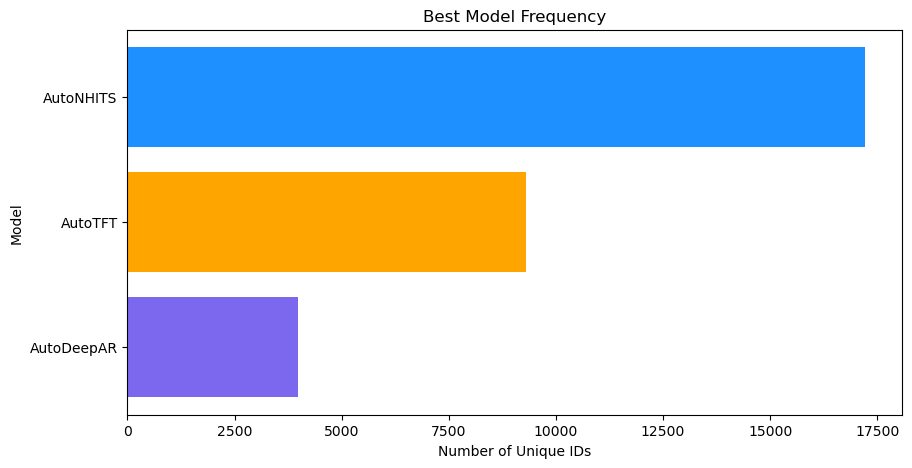

In [325]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Adjust the size as needed
plt.barh(summary_df['model'], summary_df['unique_ids'], color=['mediumslateblue', 'orange', 'dodgerblue'])  # Using a color similar to the 'viridis' palette
plt.xlabel('Number of Unique IDs')  # X-axis label
plt.ylabel('Model')  # Y-axis label
plt.title('Best Model Frequency')  # Title of the plot
plt.show()

With this information, we can now determine which model performed best for each series in the historical data, and we will save these results in a dictionary.

In [310]:
best_model = {
    'AutoNHITS': eval[eval['best_model'] == 'AutoNHITS']['unique_id'].values,
    'AutoDeepAR': eval[eval['best_model'] == 'AutoDeepAR']['unique_id'].values,
    'AutoTFT': eval[eval['best_model'] == 'AutoTFT']['unique_id'].values
}

## 4. Fit and Predict 

In this section, we will train the `Auto` models on the entire dataset using the `fit` method. Following this, we will employ the `predict` method to forecast sales for the next 28 days.

In [25]:
nf.fit(Y_df)

In [ ]:
fcst_df = nf.predict()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [331]:
# Load previously generated results 
fcst_df = pd.read_csv('fcst_df.csv')

As before, we will only select the point forecasts of each model. 

In [332]:
fcst_df = fcst_df.reset_index()
fcst_df = fcst_df[['unique_id', 'ds', 'AutoNHITS', 'AutoDeepAR', 'AutoTFT']]
fcst_df.head() 

,unique_id,ds,AutoNHITS,AutoDeepAR,AutoTFT
0,FOODS_1_001_CA_1,2016-05-23,0.839,0.78,1.009
1,FOODS_1_001_CA_1,2016-05-24,0.895,0.70,1.019
2,FOODS_1_001_CA_1,2016-05-25,0.758,0.79,1.028
3,FOODS_1_001_CA_1,2016-05-26,0.683,0.63,0.925
4,FOODS_1_001_CA_1,2016-05-27,0.827,0.68,0.914


Now for each series, we will select the best model according to the results of the time series cross-validation. 

In [336]:
best_model_dfs = []  # A list to hold the best model for each unique_id

for model in models:
    model_df = fcst_df[fcst_df['unique_id'].isin(best_model[model])]
    model_df = model_df.rename(columns={model: 'best_model'})
    model_df = model_df.drop(columns=[col for col in best_model.keys() if col != model])
    best_model_dfs.append(model_df)

forecast = pd.concat(best_model_dfs, axis=0)
forecast.head()


,unique_id,ds,best_model
0,FOODS_1_001_CA_1,2016-05-23,0.839
1,FOODS_1_001_CA_1,2016-05-24,0.895
2,FOODS_1_001_CA_1,2016-05-25,0.758
3,FOODS_1_001_CA_1,2016-05-26,0.683
4,FOODS_1_001_CA_1,2016-05-27,0.827


We can plot the results using the `plot_series` function from utilsforecast.

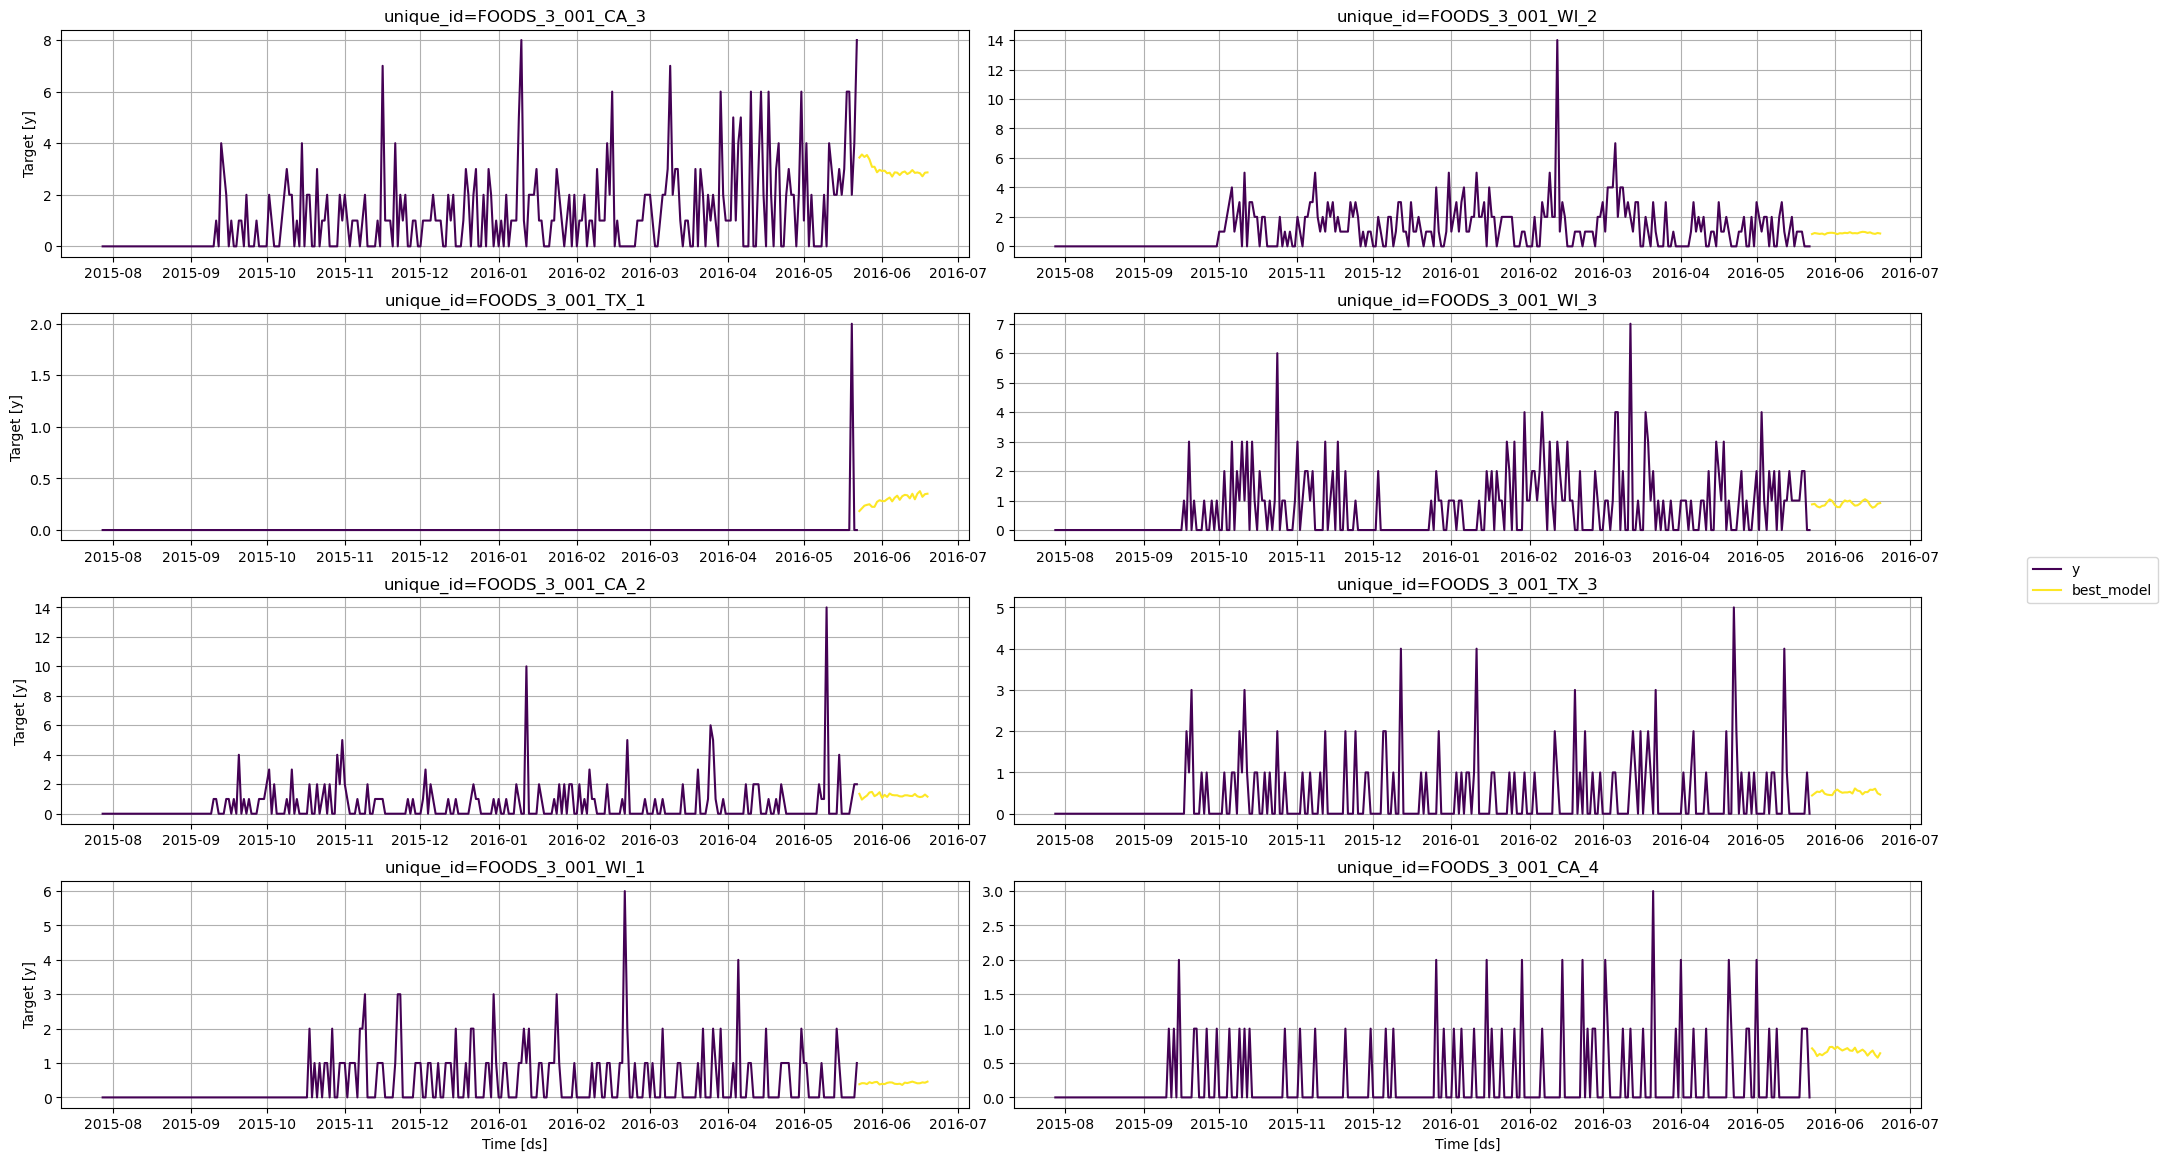

In [335]:
plot_series(Y_df, forecast, max_insample_length=300)

## 5. Evaluate the Results 

Finally, we will evaluate the 28-day-ahead forecast generated in the previous section against the actual sales values from the M5 Competition. Our goal is to replicate the evaluation process used in the accuracy track, which used the Weighted Root Mean Scaled Squared Error (RMSSE) as the evaluation metric. This evaluation is applicable only if you have generated a forecast for the complete dataset. If not, you can evaluate your forecast using the Root Mean Squared Error (RMSE), or any other accuracy metric, as described in Section 3.

To compute the WRMSSE, we require static variables for each `unique_id`. These static variables include contextual information about each unique series in the dataset and they can be downloaded from datasetsforecast, a Nixtla library that offers several publicly available datasets for time series forecasting. This library also contains a function to compute the WRMSSE.

In [337]:
from datasetsforecast.m5 import M5, M5Evaluation

To download and load the test set of the M5 Competition, we need to select a directory. For convenience, we will use the current working directory

In [344]:
import os 

directory = os.getcwd()
M5.download(directory)
_, _, S_df = M5.load(directory) # load only 
S_df.head()

,unique_id,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA
1,FOODS_1_001_CA_2,FOODS_1_001,FOODS_1,FOODS,CA_2,CA
2,FOODS_1_001_CA_3,FOODS_1_001,FOODS_1,FOODS,CA_3,CA
3,FOODS_1_001_CA_4,FOODS_1_001,FOODS_1,FOODS,CA_4,CA
4,FOODS_1_001_TX_1,FOODS_1_001,FOODS_1,FOODS,TX_1,TX


To compute the WRMSSE, we need to transform the forecast from long to wide format, rename the columns, and merge the static variables. 

In [345]:
y_hat = forecast.pivot(index='unique_id', columns='ds', values='best_model')
y_hat.columns = ['d_' + str(i + 1) for i in range(len(y_hat.columns))]
res = y_hat.merge(S_df, on='unique_id', how='left')
res.head()


,unique_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_24,d_25,d_26,d_27,d_28,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_1,0.839,0.895,0.758,0.683,0.827,0.824,0.931,0.989,0.917,...,0.837,0.797,0.848,0.898,0.967,FOODS_1_001,FOODS_1,FOODS,CA_1,CA
1,FOODS_1_001_CA_2,0.620,0.570,0.600,0.600,0.720,0.700,0.530,0.700,0.630,...,0.650,0.600,0.670,0.580,0.680,FOODS_1_001,FOODS_1,FOODS,CA_2,CA
2,FOODS_1_001_CA_3,1.056,0.851,0.829,0.876,1.084,1.198,1.262,1.065,0.890,...,0.862,0.789,0.979,1.108,1.171,FOODS_1_001,FOODS_1,FOODS,CA_3,CA
3,FOODS_1_001_CA_4,0.512,0.474,0.415,0.401,0.414,0.375,0.389,0.409,0.464,...,0.499,0.490,0.485,0.466,0.496,FOODS_1_001,FOODS_1,FOODS,CA_4,CA
4,FOODS_1_001_TX_1,0.990,1.090,1.130,1.320,1.170,0.990,1.200,1.080,1.140,...,1.140,1.090,1.020,1.070,1.050,FOODS_1_001,FOODS_1,FOODS,TX_1,TX


To use the `evaluate` function from the `M5Evaluation` class, we need to provide the directoy where the data was downloaded and the forecasts in the previous format. 

In [348]:
results = M5Evaluation.evaluate(directory=directory, y_hat=res)

In [349]:
results

,wrmsse
Total,0.846097
Level1,0.672951
Level2,0.711318
Level3,0.746686
Level4,0.758965
Level5,0.887049
Level6,0.807268
Level7,0.905766
Level8,0.821931
Level9,0.909346


At the lowest level of the hierarchy, where we generated the forecasts, we achieved a WRMSSE of 0.911. This score places the forecast within the [top 50 entries](https://www.sciencedirect.com/science/article/pii/S0169207021001874) at this level, showcasing the success of using NeuralForecast.